## Projeto
Classificação binária - Real ou Deepfake.

---

Link do desafio no Kaggle:
https://www.kaggle.com/competitions/image-classification-real-or-ai-generated-photo/data

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from PIL import Image
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

#### Investigação do Dataset

In [4]:
notebook_path = Path().resolve()

dataset_base_path = notebook_path.parent / "dataset/"

train_path = dataset_base_path / "train/train"
test_path = dataset_base_path / "test/test"

train_images = sorted(os.listdir(train_path), key=lambda x: int(os.path.splitext(x)[0]))
test_images = sorted(os.listdir(test_path), key=lambda x: int(os.path.splitext(x)[0]))

train_labels = pd.read_csv(dataset_base_path / "train.csv")
test_labels = pd.read_csv(dataset_base_path / "test.csv")

#### Imprmime algumas imagens do dataset

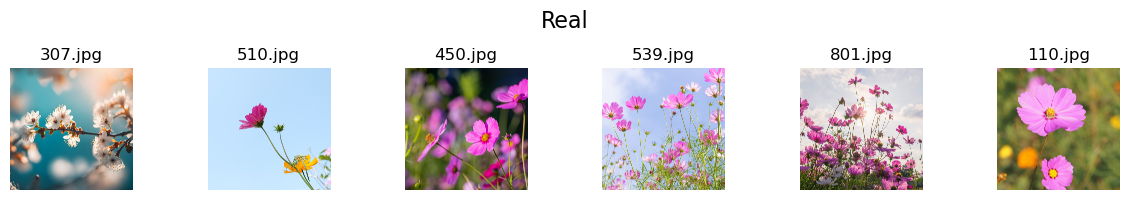

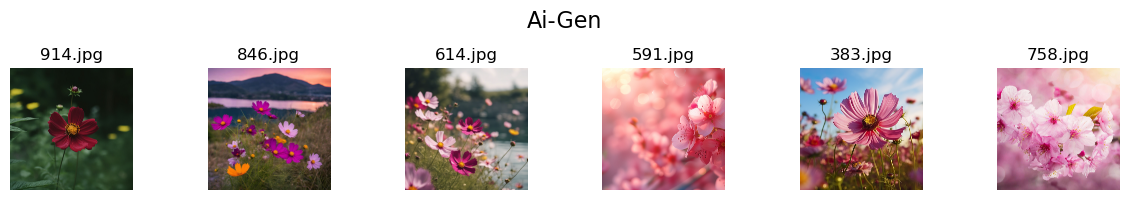

In [5]:
def print_images(images, label, total_images):
    sample_images = random.sample(images, total_images)
    
    fig, axes = plt.subplots(1, total_images, figsize=(12, 2))
    fig.suptitle(label, fontsize=16)
    for ax, img_name in zip(axes.flatten(), sample_images):
        img = Image.open(train_path / img_name)
        ax.imshow(img)
        ax.set_title(img_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

label_real_images = 1
label_ai_generated = 0

total_images = 6
real_train_images = train_labels[train_labels['Label'] == label_real_images]['Image'].tolist()
fake_train_images = train_labels[train_labels['Label'] == label_ai_generated]['Image'].tolist()

print_images(images=real_train_images, label="Real", total_images=total_images)
print_images(images=fake_train_images, label="Ai-Gen", total_images=total_images)

In [6]:
print("Check class balacing")
print(train_labels['Label'].value_counts().to_dict())

print()
print(f"Train samples: {len(train_images)}")
print(f"Test samples: {len(test_images)}")

print()
print("Sample of Labels Table")
print(train_labels.head())

Check class balacing
{1: 478, 0: 467}

Train samples: 945
Test samples: 402

Sample of Labels Table
   Image  Label
0  1.jpg      0
1  2.jpg      0
2  3.jpg      1
3  4.jpg      1
4  5.jpg      0


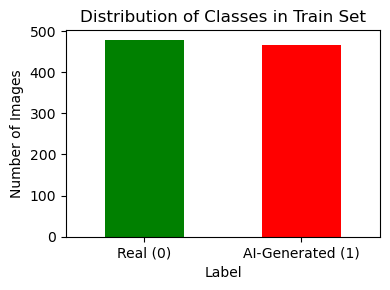

In [7]:
plt.figure(figsize=(4, 3))
train_labels['Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribution of Classes in Train Set")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks([0,1], ['Real (0)', 'AI-Generated (1)'], rotation=0)
plt.tight_layout()
plt.show()

Como mostrado no gráfico acima, as classes estão balanceadas no conjunto de teste, isto facilita a análise e evita chances de viés de classe.

#### Separação do Dataset para treino

In [8]:
labels_dict = dict(zip(train_labels['Image'], train_labels['Label']))

train_targets = [labels_dict[f] for f in train_images]

X_train_imgs, X_val_imgs, y_train, y_val = train_test_split(
    train_images, train_targets, test_size=0.2, stratify=train_targets, random_state=42
)

print(X_train_imgs[:5], y_train[:5])
print(X_val_imgs[:5], y_val[:5])

['771.jpg', '774.jpg', '659.jpg', '791.jpg', '692.jpg'] [0, 1, 0, 1, 1]
['132.jpg', '365.jpg', '366.jpg', '942.jpg', '476.jpg'] [1, 0, 0, 0, 0]


#### Pre-processamento

In [17]:
def load_images(image_list, base_path, target_size=(128, 128)):
    data = []
    for i, img_name in enumerate(image_list):
        if i % 100 == 0:
            print(f"Loading image {i+1} of {len(image_list)}: {img_name}")
        img_path = base_path / img_name
        img = Image.open(img_path).convert("RGB").resize(target_size)
        data.append(np.array(img) / 255.0)
    return np.array(data)

print(f"Loading training images...")
X_train = load_images(X_train_imgs, train_path)
print(f"Loading validation images...")
X_val = load_images(X_val_imgs, train_path)
# print(f"Loading test images...")
# X_test = load_images(test_images, test_path)

y_train = np.array(y_train)
y_val = np.array(y_val)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
# print("Test set:", X_test.shape)

Loading training images...
Loading image 1 of 756: 771.jpg
Loading image 101 of 756: 743.jpg
Loading image 201 of 756: 676.jpg
Loading image 301 of 756: 792.jpg
Loading image 401 of 756: 193.jpg
Loading image 501 of 756: 552.jpg
Loading image 601 of 756: 185.jpg
Loading image 701 of 756: 433.jpg
Loading validation images...
Loading image 1 of 189: 132.jpg
Loading image 101 of 189: 69.jpg
Train set: (756, 128, 128, 3) (756,)
Validation set: (189, 128, 128, 3) (189,)


In [18]:
def get_random_forest():
    return RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

In [19]:
# Random Forest trabalha em 2D: [amostras, features]
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

rf_model = get_random_forest()
rf_model.fit(X_train_flat, y_train)

y_pred_rf = rf_model.predict(X_val_flat)

### Extração de caracteristicas

In [11]:
def extract_features(image_list, base_path, target_size=(128, 128), bins=16):
    features = []
    for img_name in tqdm(image_list, desc="Extracting features"):
        img_path = base_path / img_name
        img = Image.open(img_path).convert("RGB").resize(target_size)
        arr = np.array(img) / 255.0

        mean = arr.mean(axis=(0,1))
        std = arr.std(axis=(0,1))

        hist = np.histogram(arr, bins=bins, range=(0,1))[0]
        hist = hist / hist.sum()

        feat = np.concatenate([mean, std, hist])
        features.append(feat)
    return np.array(features)

X_train_feat = extract_features(X_train_imgs, train_path)
X_val_feat = extract_features(X_val_imgs, train_path)

Extracting features: 100%|██████████| 189/189 [00:22<00:00,  8.25it/s]


In [23]:
def get_grid_search_rf():
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    rf = get_random_forest()
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    return grid_search

In [ ]:
grid_search = get_grid_search_rf()
grid_search.fit(X_train_feat, y_train)

print("Best params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_manual_extract_gs = best_rf.predict(X_val_feat)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


#### Resultados

In [13]:
def print_results(y_val, y_pred):
    print("\nValidation results:")

    print(classification_report(y_val, y_pred, digits=3))
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")

    y_val = np.array(y_val, dtype=int)
    y_pred = np.array(y_pred, dtype=int)

    cm = confusion_matrix(y_val, y_pred, labels=[class_id for class_id in range(2)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AI-Generated (0)', 'Real (1)'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

#### Resultados da Random Forest sem Extração de caracteristicas


Validation results:
              precision    recall  f1-score   support

           0      0.752     0.849     0.798        93
           1      0.833     0.729     0.778        96

    accuracy                          0.788       189
   macro avg      0.793     0.789     0.788       189
weighted avg      0.793     0.788     0.788       189

Accuracy: 0.788


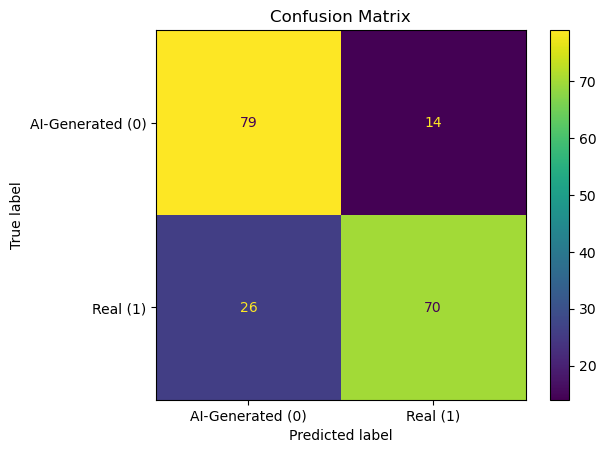

In [25]:
print_results(y_val, y_pred_rf)

#### Resultados da RF com GridSearchCV e Extração manual de caracteristicas


Validation results:
              precision    recall  f1-score   support

           0      0.728     0.806     0.765        93
           1      0.791     0.708     0.747        96

    accuracy                          0.757       189
   macro avg      0.759     0.757     0.756       189
weighted avg      0.760     0.757     0.756       189

Accuracy: 0.757


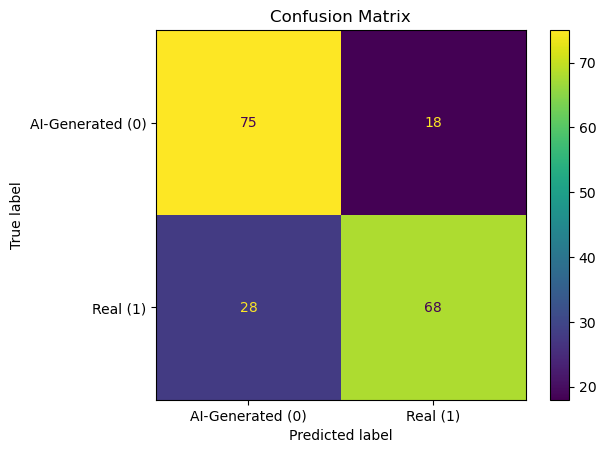

In [26]:
print_results(y_val, y_pred_manual_extract_gs)

In [16]:
# Adicionar augmentation de dados?